In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import qsat,humidsat
from orographicConvectionTheory.orographicConvectionTheory import *
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,w_to_Tprime,linear_w_generalized
from tools.generalTools import compute_N
from tools.wrfHrTools import *

SCRATCH='/global/cscratch1/sd/qnicolas/'

import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

In [2]:
xr.set_options(display_style='text') 

In [3]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client()
client

Client Scheduler: tcp://127.0.0.1:43345 Dashboard: /user/qnicolas/cori-shared-node-cpu/proxy/8787/status,Cluster Workers: 8 Cores: 64 Memory: 540.14 GB


In [1]:
import sys;import os
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)
from tools.wrfHrTools import *

path = "/global/cscratch1/sd/qnicolas/wrfdata/saved/"
sims = ["channel.wrf.100x2.mountain.60lev.500m.12mps.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.3km",
        "channel.wrf.100x2.mountain.60lev.500m.3km",
        "channel.wrf.100x2.mountain.60lev.3km",
        "channel.wrf.100x2.mountain.60lev.dry.3km",
        "channel.wrf.100x2.mountain.60lev.500m.12mps.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.296K.new.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new2.3km",
        "channel.wrf.100x2.mountain.60lev.500m.new.3km",
        ]
for i,sim in enumerate(sims):
    test = extract_wrfout(path+sim+'/')
    test = extract_wrfpro(path+sim+'/')
    if i<5:
        for file in os.listdir(path+sim+"/diags/"):
            try:
                test = xr.open_dataset(path+sim+"/diags/"+file)
            except OSError:
                try:
                    test = xr.open_zarr(path+sim+"/diags/"+file)
                except:
                    print("Could not open "+ path+sim+"/diags/"+file)
                
    if i<3 or (i>=5 and i<8):
        test = xr.open_dataset(path+sim+"/wrfinput_d01")
    

Could not open /global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/old_etalevs
Could not open /global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.dry.3km/diags/old


# Creating "restart" init files

In [29]:
#deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/wrfinput_d01')
#deepoutput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/wrfout_d01_1970-04-24_06_00_00').isel(Time=slice(7,8))

#deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfinput_d01')
#deepoutput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfout_d01_1971-01-01_06_00_00').isel(Time=slice(11,12))

deepinput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/wrfinput_d01')
deepoutput500 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.3km/wrfout_d01_1970-09-06_06_00_00').isel(Time=slice(11,12))

In [30]:
## new 500m classic run

#input_vars = [name for name in deepinput500.data_vars]
#output_vars = [name for name in deepoutput500.data_vars]
#intersec_vars = [name for name in input_vars if name in output_vars]
updated_vars = ['U','V','W','PH','T','MU','P','Q2','T2','TH2','PSFC','U10','V10','QVAPOR','QCLOUD','QRAIN','QICE','QSNOW','QGRAUP','SMOIS','SH2O','SNOW','TSK','TG','CM','CH','T2V','T2B','Q2V','Q2B','TRAD','RUNSF','RUNSB','ECAN','EDIR','ETRAN','FSA','FIRA','TR','EVC']


from netCDF4 import Dataset
ncfile = Dataset('/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel296/test/em_beta_plane/wrfinput_d01', 'r+') # for modification
for name in updated_vars:
    print(name)
    ncfile[name][:]=np.array(deepoutput500[name])
ncfile.close()

U
V
W
PH
T
MU
P
Q2
T2
TH2
PSFC
U10
V10
QVAPOR
QCLOUD
QRAIN
QICE
QSNOW
QGRAUP
SMOIS
SH2O
SNOW
TSK
TG
CM
CH
T2V
T2B
Q2V
Q2B
TRAD
RUNSF
RUNSB
ECAN
EDIR
ETRAN
FSA
FIRA
TR
EVC


In [ ]:
## I don't know where this was from but I kept it
from createSounding import moist_adiabat
z = np.arange(0.,50001,50.)

def moist_adiabat(z,SST):
    p = 1000*np.exp(-9.81*z/(287.*270.)) * units.hPa
    Tp = mpcalc.moist_lapse(p,(SST-1)*units.K)
    qp = 0.8*mpcalc.saturation_mixing_ratio(p,Tp)
    
    ztrop1=17e3
    ztrop2=19e3
    idx1 = np.argmin((z-ztrop1)**2)
    idx2 = np.argmin((z-ztrop2)**2)
    Tp[idx1:idx2] = Tp[idx1]
    Tp[idx2:] = Tp[idx1]+2e-3*(z[idx2:]-ztrop2)*units.K
    thetap = mpcalc.potential_temperature(p,Tp)
    thicknesses = [mpcalc.thickness_hydrostatic(p, Tp,bottom=p[i] ,depth=p[i]-p[i+1])/units.m for i in range(len(p)-1)]
    zp = np.concatenate([[0.],np.cumsum(thicknesses)])
    
    thetaz = np.interp(z,zp,(thetap/units.K))
    qz = np.interp(z,zp,qp)
    idxs = z<35000
    return z[idxs], np.array([float(x) for x in thetaz])[idxs],np.array([float(x) for x in qz])[idxs]

z,thetaz,qz = moist_adiabat(z,SST)

# Checking spinups

In [6]:
#%%time
#deepchannel_500 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/')
#T_hov = deepchannel_500.T.mean(['south_north','west_east']).load()
#Q_hov = deepchannel_500.QVAPOR.mean(['south_north','west_east']).load()
#T_hov.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T.t_z_hovmoeller.nc')
#q_hov.to_netcdf('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.QVAPOR.t_z_hovmoeller.nc')

In [4]:
T_hov=xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/diags/wrf.T.t_z_hovmoeller.nc')
Tprime_hov = (T_hov-T_hov.isel(Time=0))

In [5]:
%%time
deepinput_500_12 = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/wrfinput_d01')
deepchannel_500_12 = extract_wrfout('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.12mps.3km/')
T_hov_12 = deepchannel_500_12.T.mean(['south_north','west_east']).load()
Tprime_hov_12 = (T_hov_12-T_hov_12.isel(Time=0))


CPU times: user 6.61 s, sys: 781 ms, total: 7.39 s
Wall time: 59 s


In [9]:
z_mean = 1/9.81*(deepinput_500_12.PHB.isel(south_north=0,west_east=0,Time=0)+deepchannel_500_12.PH.isel(west_east=slice(2000,3000),Time=slice(-10,-1)).mean(['west_east','south_north','Time'])).load()


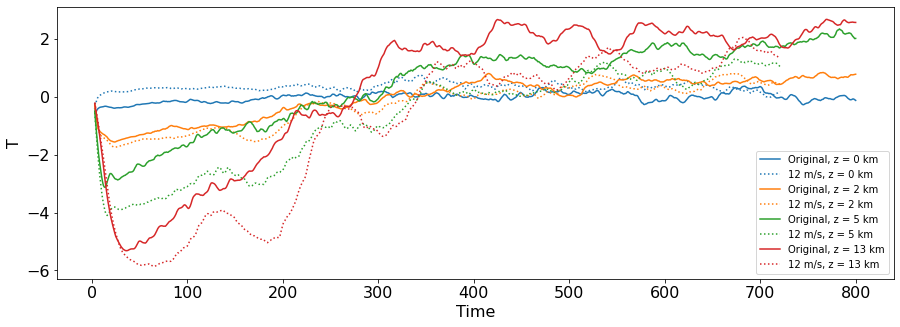

In [20]:
plt.figure(figsize=(15,5))
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j,i in enumerate((5,15,30,50)):
    Tprime_hov.rolling(Time=4).mean().isel(bottom_top=i).plot(label="Original, z = %i km"%(z_mean[i]/1e3),color=clrs[j])
    Tprime_hov_12.rolling(Time=4).mean().isel(bottom_top=i).plot(label="12 m/s, z = %i km"%(z_mean[i]/1e3),color=clrs[j],linestyle=':')
plt.legend(fontsize=10,loc=4)
#plt.xlim(0,50)

# Checking spinups - 2

In [19]:
newsim = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new2.3km/")


In [20]:
Tprime_hov_new = newsim.T.mean(['south_north','west_east'])
Tprime_hov_new = Tprime_hov_new - Tprime_hov_new.isel(Time=0)

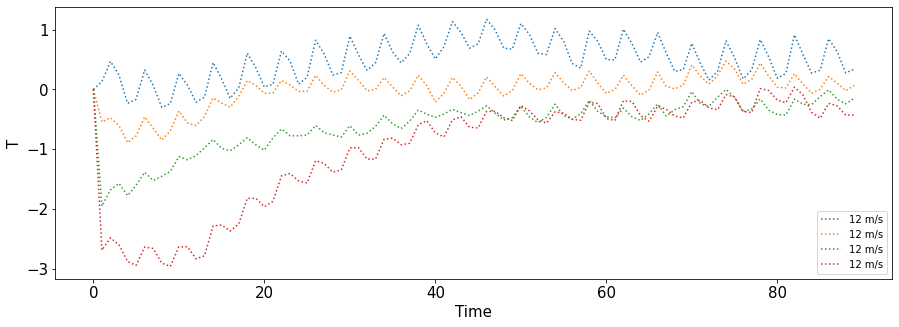

In [23]:
plt.figure(figsize=(15,5))
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j,i in enumerate((5,15,30,50)):
    #Tprime_hov.rolling(Time=4).mean().isel(bottom_top=i).plot( label="Original",color=clrs[j])
    Tprime_hov_new.isel(bottom_top=i).plot(label="12 m/s",color=clrs[j],linestyle=':')
plt.legend(fontsize=10,loc=4)
#plt.xlim(0,50)

In [4]:
newsim = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/")


In [5]:
Tprime_hov_new = newsim.T.mean(['south_north','west_east'])
Tprime_hov_new = Tprime_hov_new - Tprime_hov_new.isel(Time=0)

In [6]:
Tprime_hov_new=Tprime_hov_new[:200]

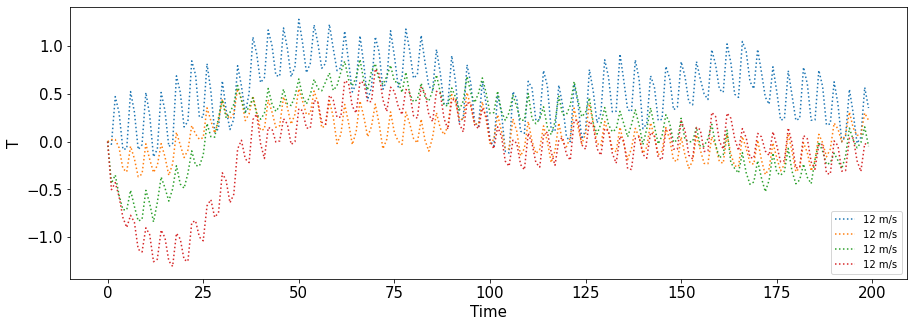

In [8]:
plt.figure(figsize=(15,5))
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j,i in enumerate((5,15,30,50)):
    #Tprime_hov.rolling(Time=4).mean().isel(bottom_top=i).plot( label="Original",color=clrs[j])
    Tprime_hov_new.isel(bottom_top=i).plot(label="12 m/s",color=clrs[j],linestyle=':')
plt.legend(fontsize=10,loc=4)
#plt.xlim(0,50)

In [9]:
Tprime_hov_new = newsim.QVAPOR.mean(['south_north','west_east'])
Tprime_hov_new = Tprime_hov_new - Tprime_hov_new.isel(Time=0)

In [10]:
Tprime_hov_new=Tprime_hov_new[:200]

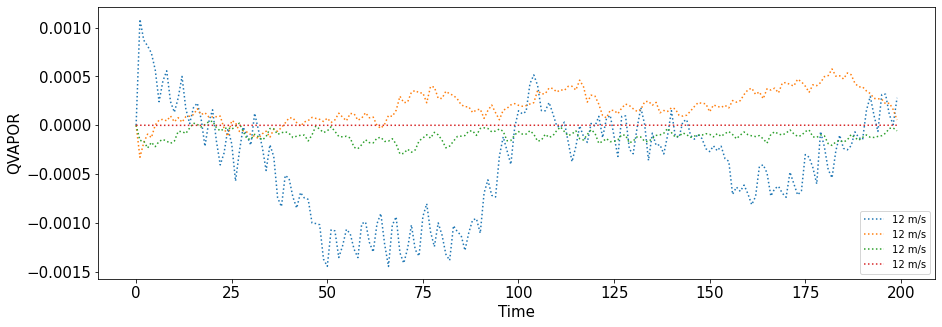

In [11]:
plt.figure(figsize=(15,5))
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']
for j,i in enumerate((5,15,30,50)):
    #Tprime_hov.rolling(Time=4).mean().isel(bottom_top=i).plot( label="Original",color=clrs[j])
    Tprime_hov_new.isel(bottom_top=i).plot(label="12 m/s",color=clrs[j],linestyle=':')
plt.legend(fontsize=10,loc=4)
#plt.xlim(0,50)

In [13]:
sim = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/")
rain = sim.RAINNC.mean(['south_north','west_east']).diff('Time')


newsim = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/")
rain1 = newsim.RAINNC.mean(['south_north','west_east']).diff('Time')

newsim = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new2.3km/")
rain2 = newsim.RAINNC.mean(['south_north','west_east']).diff('Time')


(0.0, 200.0)

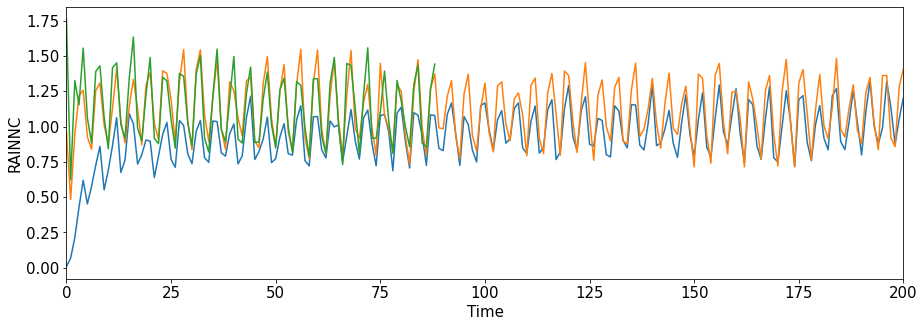

In [15]:
plt.figure(figsize=(15,5))
rain.plot(label='original')
rain1.plot(label='new')
rain2.plot(label='new2')
plt.xlim(0,200)

In [17]:
300/23.25

12.903225806451612

# Check inputs

In [44]:
wrfinput = xr.open_dataset("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel296/test/em_beta_plane/wrfinput_d01")


In [46]:
wrfinput.SST.mean()

<xarray.DataArray 'SST' ()>
array(296., dtype=float32)

In [47]:
wrfinput.U[0,5:].mean()

<xarray.DataArray 'U' ()>
array(-10.107369, dtype=float32)

In [2]:
class Region:
    pass
Ghats       = Region()
Myanmar     = Region()
Vietnam     = Region()
Malaysia    = Region()
Philippines = Region()
Newbritain  = Region()

Ghats      .U0 = 10; Ghats      .V0 =  1; Ghats      .P0 = 2
Myanmar    .U0 =  9; Myanmar    .V0 =  9; Myanmar    .P0 = 7
Vietnam    .U0 = -7; Vietnam    .V0 = -5; Vietnam    .P0 = 4
Malaysia   .U0 = -7; Malaysia   .V0 = -5; Malaysia   .P0 = 8
Philippines.U0 = -9; Philippines.V0 = -3; Philippines.P0 = 5
Newbritain .U0 = -9; Newbritain .V0 =  7; Newbritain .P0 = 6


In [3]:
regs = (Ghats      ,Myanmar    ,Vietnam    ,Malaysia   ,Philippines,Newbritain )
for reg in regs:
    print(np.sqrt(reg.U0**2+reg.V0**2))

10.04987562112089
12.727922061357855
8.602325267042627
8.602325267042627
9.486832980505138
11.40175425099138
